In [4]:
from numba import *
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
N_particules = 300
N_interation = 10*N_particules**3

In [14]:
def add_line(file,line,message=False):
    table = np.loadtxt(file)
    if message:
        print('in')
    table_new = np.concatenate((table,np.array([line])),axis=0)
    np.savetxt(file,table_new)
    if message:
        print('out')

def is_file(fname,folder='./'):
    return (np.array(os.listdir(folder))==fname).any()

In [15]:
class Ising3D():
    """
    Pi = J/kT
    3 'lattice_types' :
        - cubic : all the bounds are taken into account
        - Wurtzite : each particle has 5 neighbours as in the Wurtzite lattice
        - Hbounds : each particle is bounded with 4 other
    """
    def __init__(self,N,Pi,lattice_type='cubic'):
        self.N = N
        self.Pi = Pi
        if not lattice_type in ['cubic','Wurtzite','Hbounds']:
            raise Exception(f"{lattice_type} should be either 'cubic' , 'Wurtzite' or 'Hbounds'")
        self.lattice_type = lattice_type
        self.state = np.random.randint(low = 0, high = 2, size = (N,N,N))*2-1
    
    @property
    def fname(self):
        return f"results_{self.lattice_type}_{self.N}.txt"
    
    def set_state(self,state_in):
        self.state = state_in
    
    @jit
    def delta_energy(self,state, i, j, k):
        Delta_H = 2*self.Pi*state[i,j,k]*(
            (self.lattice_type not in ['Wurtzite','Hbounds'] or (i+j)%2)*state[i,(j-1)%self.N,k]
            + (self.lattice_type not in ['Wurtzite','Hbounds'] or (i+j-1)%2)*state[i,(j+1)%self.N,k]
            + (self.lattice_type not in ['Hbounds'] or (i+j+k)%2)*state[(i-1)%self.N,j,k]
            + (self.lattice_type not in ['Hbounds'] or (i+j+k-1)%2)*state[(i+1)%self.N,j,k]
            + state[i,j,(k-1)%self.N]
            + state[i,j,(k+1)%self.N])
        return Delta_H
    
    @jit
    def iterate(self,n=1,message=False):
        for _ in range(n):
            if message and int(_%10**6) == 0:
                print(_)
            i,j,k =  np.random.randint(low=0, high=self.N, size=3)
            Delta_H = self.delta_energy(self.state, i, j, k)
            if Delta_H < 0 or np.random.random() < np.exp(-Delta_H):
                self.state[i,j,k] *= -1
    
    @jit
    def energy(self):
        H = 0
        for i in range(self.N):
            for j in range(self.N):
                for k in range(self.N):
                    H += -self.state[i,j,k]*self.Pi*(
                        (i+j+k)%2*self.state[i,(j-1)%self.N,k]
                        + (i+j+k+1)%2*self.state[i,(j+1)%self.N,k]
                        + self.state[(i-1)%self.N,j,k]
                        + self.state[(i+1)%self.N,j,k]
                        + self.state[i,j,(k-1)%self.N]
                        + self.state[i,j,(k+1)%self.N])
        return H

    def aimantation(self):
        return np.mean(self.state)
    
    def save(self,message=True):
        if not is_file(self.fname):
            np.savetxt(self.fname,np.zeros((2,2)))
            print(f'Creating new file {self.fname}')
        add_line(file=self.fname,line=[self.Pi,self.aimantation()],message=message)

C:\Users\bjona\AppData\Local\Temp\ipykernel_18820\4184339517.py:25: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_energy(self,state, i, j, k):
C:\Users\bjona\AppData\Local\Temp\ipykernel_18820\4184339517.py:36: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterate(self,n=1,message=False):
C:\Users\bjona\AppData\Local\Temp\ipykernel_18820\4184339517

# Simulation

In [22]:
List_Pi = [0.1,1,10]

for Pi in List_Pi:
    ising = Ising3D(N_particules,Pi,lattice_type='Hbounds')
    ising.set_state(np.ones((N_particules,N_particules,N_particules)))
    ising.iterate(n=N_interation,message=True)
    ising.save(message=True)
    #L_N.append(ising.aimantation())
    #L_N.append(num_features)

0
in
out
0
in
out
0
in
out


# Results

In [19]:
fname = 'results_cubic_300.txt'
data = np.loadtxt(fname)
List_Pi_data = data[:,0]
List_M_data = data[:,1]

Text(0, 0.5, 'Aimantation Moyenne $\\dfrac{M}{N}$')

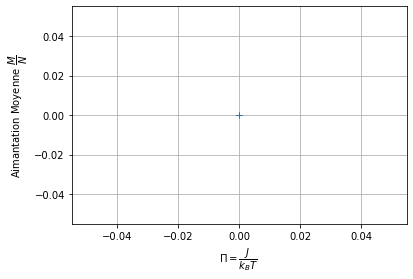

In [20]:
plt.plot(List_Pi_data,List_M_data,'+')
plt.grid()
plt.xlabel(r'$\Pi = \dfrac{J}{k_B T}$')
plt.ylabel(r'Aimantation Moyenne $\dfrac{M}{N}$')